In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

#from helper2 import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

%load_ext autoreload
%autoreload 2

import torchvision

from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

from sdlbfgs import *
from helper import *

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### FashionMNIST dataset
The FashionMNIST dataset is loaded.

In [3]:
trainset = datasets.FashionMNIST('', download=True, train=True, transform=transform)
valset = datasets.FashionMNIST('', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

1%|          | 212992/26421880 [00:00<00:12, 2062966.49it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to FashionMNIST/raw/train-images-idx3-ubyte.gz
26427392it [00:00, 81184849.12it/s]
Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw
32768it [00:00, 791489.31it/s]
4423680it [00:00, 39650765.95it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw
Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw

8192it [00:00, 238139.63it/s]
0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw
Processing...
Done!
26427392it [00:00, 94252815.80it/s]
Ext

In [4]:
print("Training and test sets information is displayed.\n\n")
print("Trainset:\n",trainset)
print("Testset:\n",valset)

Training and test sets information is displayed.


Trainset:
 Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Testset:
 Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: PATH_TO_STORE_TESTSET
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [6]:
print(valloader)
len(valloader)

157

64 images in each batch and each image has a dimension of 28 x 28 pixels


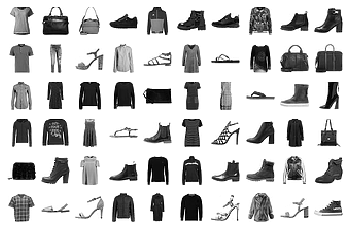

In [5]:
# A subset of a batch is plotted to show a sample of the dataset. 
dataiter = iter(trainloader)
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Neural Network 

### Model definition
The model is defined, specifying the structure of the neural network.

### Model A: FCNN
Fully connected neural network, with hidden layer structure through vector *hidden_sizes*.

In [8]:
# Input and output sizes and network structure are defined.
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
print(modelA)

# Loss of the model is defined.
criterion = nn.NLLLoss()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


### Model B: CNN
Convolutional neural network composed of two convolutional layers and two fully connected layers.

In [6]:
# The size of the images is computed.
images,_=dataiter.next()
image_size=images[0].shape[1]
# Using nn.CrossEntropyLoss allows to avoid specifying LogSoftmax as final layer.
criterion = nn.CrossEntropyLoss()
# Depending on the size of the image, a CNN model is built.
modelB=ConvNet(image_size)
print(modelB)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


## SdLBFGS

### Fully connected network

In [15]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
model=fully_connected_NN(sizes)
# Loss of the model is defined.
criterion = nn.NLLLoss()

method = "SdLBFGS"
optimizer = SdLBFGS(model.parameters())

epochs = 30
train_losses_fcnn, test_losses_fcnn, train_accuracy_fcnn, test_accuracy_fcnn, training_time_fcnn = optimize(optimizer, epochs, trainloader, valloader, model, criterion , method )


Epoch 0
Training loss: 0.4729530437192175
Number Of Images Tested = 10000
Model Accuracy = 0.84
Number Of Images Tested = 60000
Model Accuracy = 0.8594833333333334
Test loss: 0.4541479273206869 

Epoch 1
Training loss: 0.3783400763374275
Number Of Images Tested = 10000
Model Accuracy = 0.8526
Number Of Images Tested = 60000
Model Accuracy = 0.8711833333333333
Test loss: 0.42099339738013636 

Epoch 2
Training loss: 0.357363991677634
Number Of Images Tested = 10000
Model Accuracy = 0.8509
Number Of Images Tested = 60000
Model Accuracy = 0.8728833333333333
Test loss: 0.41191368023301383 

Epoch 3
Training loss: 0.34692491993689334
Number Of Images Tested = 10000
Model Accuracy = 0.8567
Number Of Images Tested = 60000
Model Accuracy = 0.8787166666666667
Test loss: 0.39440831542015076 

Epoch 4
Training loss: 0.33766266924422433
Number Of Images Tested = 10000
Model Accuracy = 0.8601
Number Of Images Tested = 60000
Model Accuracy = 0.8826166666666667
Test loss: 0.38440798868419257 

Epoch 5

In [23]:
np.savetxt('SdLBFGS_fcNN_trainloss.txt', train_losses_fcnn)
np.savetxt('SdLBFGS_fcNN_testloss.txt', test_losses_fcnn)
np.savetxt('SdLBFGS_fcNN_trainacc.txt', train_accuracy_fcnn)
np.savetxt('SdLBFGS_fcNN_testacc.txt', test_accuracy_fcnn)


In [ ]:
plt.figure(1, figsize = (12,10))
plt.plot(test_losses_fcnn)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('SdLBFGS Test loss in FCNN',fontsize = 20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("SdLBFGS_test_loss_fcnn.jpg")

plt.figure(2, figsize = (12,10))
plt.plot(train_losses_fcnn)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('SdLBFGS Train loss in FCNN',fontsize = 20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("SdLBFGS_train_loss_fcnn.jpg")

plt.figure(3, figsize = (12,10))
plt.plot(train_accuracy_fcnn)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('SdLBFGS Train accuracy in FCNN',fontsize = 20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("SdLBFGS_train_accuracy_fcnn.jpg")

plt.figure(4, figsize = (12,10))
plt.plot(test_accuracy_fcnn)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('SdLBFGS Test accuracy in FCNN',fontsize = 20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("SdLBFGS_test_accuracy_fcnn.jpg")


### CNN

In [7]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# Model building
# The size of the images is computed.
images,_=dataiter.next()
image_size=images[0].shape[1]
# Using nn.CrossEntropyLoss allows to avoid specifying LogSoftmax as final layer.
criterion = nn.CrossEntropyLoss()
modelB=ConvNet(image_size)


method = "SdLBFGS"
optimizer = SdLBFGS(modelB.parameters(), history_size = 50)

epochs = 15

train_losses_cnn, test_losses_cnn, train_accuracy_cnn, test_accuracy_cnn, training_time_cnn = optimize_CNN(optimizer, epochs, trainloader, valloader, modelB, criterion , method )



Epoch 0
Training loss: 0.47926917505353245
Number Of Images Tested = 10000
Model Accuracy = 0.8802
Number Of Images Tested = 60000
Model Accuracy = 0.8882666666666666
Test loss: 0.34133576578015734 

Epoch 1
Training loss: 0.29126810333701464
Number Of Images Tested = 10000
Model Accuracy = 0.8899
Number Of Images Tested = 60000
Model Accuracy = 0.9050333333333334
Test loss: 0.3115609261165759 

Epoch 2
Training loss: 0.25682786660693857
Number Of Images Tested = 10000
Model Accuracy = 0.8975
Number Of Images Tested = 60000
Model Accuracy = 0.9138333333333334
Test loss: 0.2912386058811929 

Epoch 3
Training loss: 0.24163878809954567
Number Of Images Tested = 10000
Model Accuracy = 0.8947
Number Of Images Tested = 60000
Model Accuracy = 0.91405
Test loss: 0.29363146353109626 

Epoch 4
Training loss: 0.23473375309695568
Number Of Images Tested = 10000
Model Accuracy = 0.9005
Number Of Images Tested = 60000
Model Accuracy = 0.9208166666666666
Test loss: 0.27892097977885777 

Epoch 5
Train

In [8]:
np.savetxt('15epochs_SdLBFGS_CNN_trainloss.txt', train_losses_cnn)
np.savetxt('15epochs_SdLBFGS_CNN_testloss.txt', test_losses_cnn)
np.savetxt('15epochs_SdLBFGS_CNN_trainacc.txt', train_accuracy_cnn)
np.savetxt('15epochs_SdLBFGS_CNN_testacc.txt', test_accuracy_cnn)
np.savetxt('15epochs_SdLBFGS_CNN_testacc.txt',[training_time_cnn])

In [9]:
training_time_cnn


396.50596371094383

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


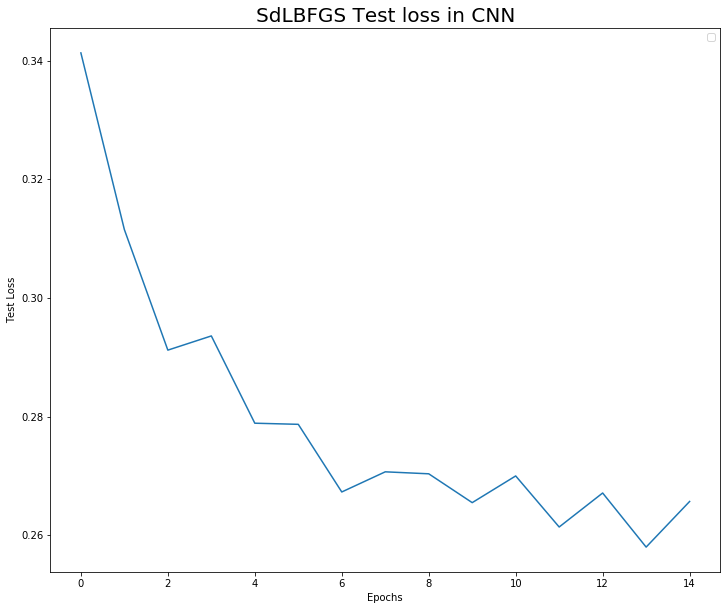

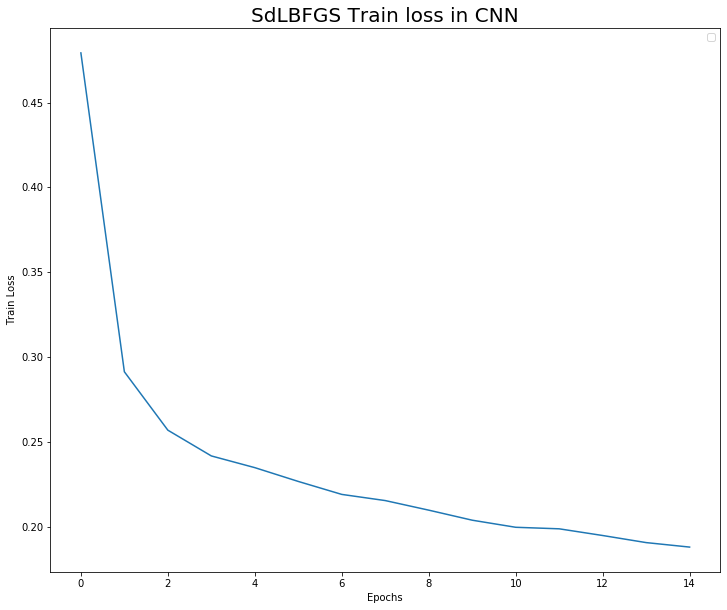

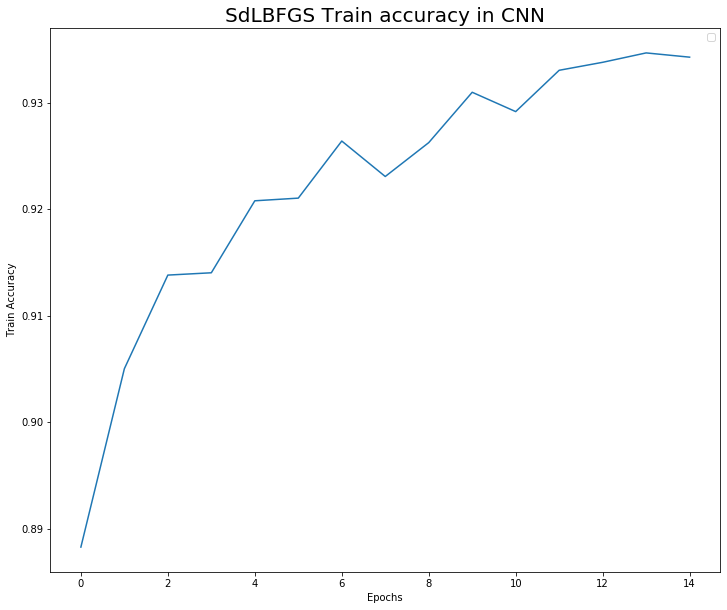

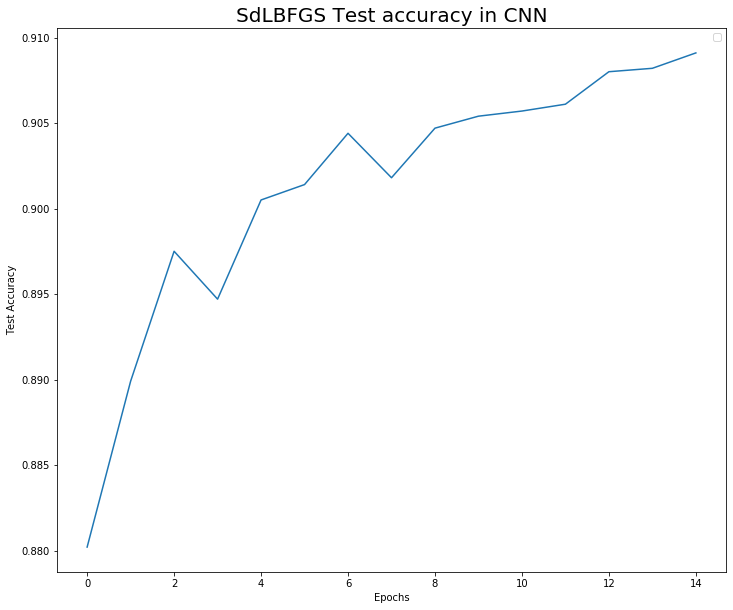

In [10]:
plt.figure(1, figsize = (12,10))
plt.plot(test_losses_cnn)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('SdLBFGS Test loss in CNN',fontsize = 20)
plt.legend()
plt.savefig("15epochs_SdLBFGS_test_loss_cnn.jpg")

plt.figure(2, figsize = (12,10))
plt.plot(train_losses_cnn)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('SdLBFGS Train loss in CNN',fontsize = 20)
plt.legend()
plt.savefig("15epochs_SdLBFGS_train_loss_cnn.jpg")

plt.figure(3, figsize = (12,10))
plt.plot(train_accuracy_cnn)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('SdLBFGS Train accuracy in CNN',fontsize = 20)
plt.legend()
plt.savefig("15epochs_SdLBFGS_train_accuracy_cnn.jpg")

plt.figure(4, figsize = (12,10))
plt.plot(test_accuracy_cnn)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('SdLBFGS Test accuracy in CNN',fontsize = 20)
plt.legend()
plt.savefig("15epochs_SdLBFGS_test_accuracy_cnn.jpg")